<h1>Strawberry Disease Semantic Segmentation</h1>  
  
  
<h3>Dataset</h3>  

Strawberry Disease Dataset is found on kaggle.com and contains images of strawberry plant including plants infected with 7 diseases typical for this plant. Dataset is well prepared for image segmentation task: data is split in train and test set, and each image is accompanied by .json file containing the points for mask reconstruction. This means that data is specifically prepared for semantic segmentation task. Total number of training images is 1450, which is not enough data for most models built for this task. To face this issue we will have to apply ML techniques such as Transfer Learning and image augmentation. Transfer Learning means that we will use prototyoe of existing model and this will improve training efficiency and accuracy. Augmentation is name for techniques to generate more data from existing dataset.  
  
<h3>Semantic Segmentation</h3>  
  
Image segmentation is a task that splits pixels of image in different fields by classifying every pixel in an image (by assigning label to it). It provides much more information than other image ML techniques such as object detection or image classification. In a way semantic segmentation can be thought of as image classification on a pixel level. If for example, there are 3 cats in the image, semantic segmentation forms a mask over each cat and pixels of all 3 cats would get classified as cat (a single label). Final output of semantic segmentation is predicted mask. This technique is used in real world applications such as biomedical applications (such as diagnosing different conditions),  as well as for self driving cars, clothes segmentation etc. Semantic segmentation is often combined with GANs.    
<h3>Transfer Learning</h3>  

To perform semantic segmentation on this dataset we will use technique called Transfer Learning which refers to using pretrained model. Because deep networks used for image segmentation usually consist of large amount of layers, this technique can save a lot of time when it comes to both building and training our model. We will use version of U-Net architecture commonly used in biomedical image segmentation, already trained on ImageNet data (we are importing weights), as a base for our model. Then we will retrain it with data adding the Strawberry Disease Dataset to the model.  
  
<h3>U-Net</h3>  

U-Net is a ccn that is mostly used for medical image processing, and uses encoder-decoder approach to semantic segmentation. Encoder extracts important features, while decoder registers patterns in data to create the mask. This means that decoder is also responsible for the output. Final output gets the resolution of original image. 

In [2]:
pip install tensorflow==2.8


  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0


In [1]:
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorflow as tf
import matplotlib as mpl
import sklearn
from PIL import Image
from keras.layers import Input, Conv2D, Reshape

<h1>EDA</h1>  
Just looking at data..

In [2]:
def load_img_segmentation(mask_json):
    json_file = json.load(open(mask_json)) #load file in json object (in a key, value format)
    shapes = json_file.get("shapes") # get values for shapes (points for mask)
    
    mask = np.zeros((json_file["imageHeight"], json_file["imageWidth"], 1)) #matrix of zeros (image dimensions)
#     draw masks
    for sh in shapes:
        points = sh["points"]
        cv2.fillConvexPoly(mask, np.array(points, 'int32'), 255) #fills polygon
        
    return mask/255

In [3]:
im = cv2.imread("data/archive/train/angular_leafspot1.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) #color conversion
mask = load_img_segmentation("data/archive/train/angular_leafspot1.json")

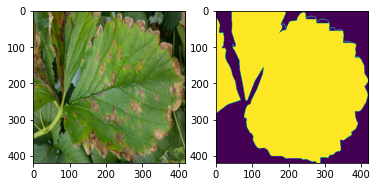

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im)
ax2.imshow(mask)

In [5]:
im = cv2.imread("data/archive/train/gray_mold83.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
mask = load_img_segmentation("data/archive/train/gray_mold83.json")

array([0., 1.])

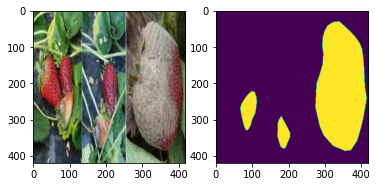

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im)
ax2.imshow(mask)
np.unique(mask)

In [7]:
im = cv2.imread("data/archive/train/anthracnose_fruit_rot2.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
mask = load_img_segmentation("data/archive/train/anthracnose_fruit_rot2.json")

array([0., 1.])

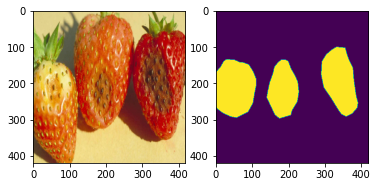

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im)
ax2.imshow(mask)
np.unique(mask)

<h1>Preprocessing</h1>  
<h3>My little experiment motivated by lack of information on data preprocessing</h3>  
Because it turned out that we have 7 classes in this problem, we will have to relabel pixels in masks so that model can distinguish different diseases.

Redefine read segmentation mask function to assign different integer values to classes. Then we will one hot encode them.  
Classes:  

0. background
1. angular_leafspot
2. anthracnose_fruit_rot
3. blossom_blight
4. gray_mold
5. leaf_spot
6. powdery_mildew_fruit
7. powdery_mildew_leaf

In [9]:
# def load_img_segmentation2(mask_json):
#     json_file = json.load(open(mask_json)) #load file in json object (in a key, value format)
#     shapes = json_file.get("shapes") # get values for shapes (points for mask)
    
#     mask = np.zeros((json_file["imageHeight"], json_file["imageWidth"], 1)) #matrix of zeros (image dimensions)
# #     draw masks
#     for sh in shapes:
#         points = sh["points"]
#         cv2.fillConvexPoly(mask, np.array(points, 'int32'), 255) #fills polygon
#         mask = cv2.resize(mask, (128,128))
#         mask[mask > 0.1] = 1
#         mask[mask <= 0.1] = 0
#     if 'angular_leafspot' in mask_json:
#         mask[mask == 1] = 1
#     elif 'anthracnose_fruit_rot' in mask_json:
#         mask[mask == 1] = 2
#     elif 'blossom_blight' in mask_json:
#         mask[mask == 1] = 3
#     elif 'gray_mold' in mask_json:
#         mask[mask == 1] = 4
#     elif 'leaf_spot' in mask_json:
#         mask[mask == 1] = 5
#     elif 'powdery_mildew_fruit' in mask_json:
#         mask[mask == 1] = 6
#     elif 'powdery_mildew_leaf' in mask_json:
#         mask[mask == 1] = 7
    
#     return mask

<h2>Update: change treshold to 0.2 and prep for 2 class use</h2>

In [10]:
def load_img_segmentation2(mask_json):
    json_file = json.load(open(mask_json)) #load file in json object (in a key, value format)
    shapes = json_file.get("shapes") # get values for shapes (points for mask)
    
    mask = np.zeros((json_file["imageHeight"], json_file["imageWidth"], 1)) #matrix of zeros (image dimensions)
#     draw masks
    for sh in shapes:
        points = sh["points"]
        cv2.fillConvexPoly(mask, np.array(points, 'int32'), 255) #fills polygon
        mask = cv2.resize(mask, (128,128))
        mask[mask > 0.2] = 1
        mask[mask <= 0.2] = 0
        
    return mask

In [11]:
# filter files of desired extension and store in provided list
def get_paths(dataset ,path_list, file_extension):
    for root, dirs, files in os.walk('data/archive/'+ dataset):
        # iterate over all files, and join .jpg or .json files
        for file in files:
            if (file.endswith(file_extension)):
                # create path
                path = os.path.join(root,file)
                # add path to list
                path_list.append(path)

Create 2 lists holding paths for images and masks so we can read and decode them in sequence.

In [12]:
train_image_paths = []
train_mask_paths = []
test_image_paths = []
test_mask_paths = []

get_paths('train', train_image_paths, 'jpg')
get_paths('train', train_mask_paths, 'json')
get_paths('test', test_image_paths, 'jpg')
get_paths('test', test_mask_paths, 'json')

print("Train images: ",len(train_image_paths))
print("Test images: ",len(test_image_paths))
print("Train masks: ",len(train_mask_paths))
print("Test masks: ",len(test_mask_paths))

Train images:  1450
Test images:  743
Train masks:  1450
Test masks:  743


In [13]:
print(train_image_paths[:5])

['data/archive/train\\angular_leafspot1.jpg', 'data/archive/train\\angular_leafspot10.jpg', 'data/archive/train\\angular_leafspot100.jpg', 'data/archive/train\\angular_leafspot101.jpg', 'data/archive/train\\angular_leafspot102.jpg']


In [14]:
print(train_mask_paths[:5])

['data/archive/train\\angular_leafspot1.json', 'data/archive/train\\angular_leafspot10.json', 'data/archive/train\\angular_leafspot100.json', 'data/archive/train\\angular_leafspot101.json', 'data/archive/train\\angular_leafspot102.json']


Sort images and masks alphabetically so we have them in lists in same orders.

In [15]:
train_image_paths.sort()
train_mask_paths.sort()
test_image_paths.sort()
test_mask_paths.sort()

Image preprocessing usually involves normalization of pixels for cnn. Here we define function to extract images and labels and return arrays with prepocessed images and labels. We will resize both image and mask according to expectations of our model, and normalize pixels of original images.

In [16]:

def extract_data(image_paths, mask_paths):

    X_=[]
    y_=[]
    count=0
    for i in range(len(image_paths)):
            
            img_1 = cv2.imread(image_paths[i])
            img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
            img_1 = cv2.resize(img_1,(128,128)) 
            img_1 = cv2.normalize(img_1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            X_.append(img_1)
            img_2 = load_img_segmentation2(mask_paths[i])
            y_.append(img_2)
            
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_,y_

<h3>Create train and validation sets from train data</h3>  
preprocessing to train is also done to test dataset.

In [17]:
X, y = extract_data(train_image_paths, train_mask_paths)
test_X, test_y = extract_data(test_image_paths, test_mask_paths)

array([0., 1.])

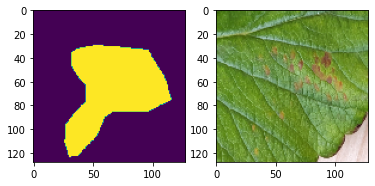

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(y[7])
ax2.imshow(X[7])
np.unique(y)

In [19]:
test_y = np.expand_dims(test_y, axis=3)
test_y.shape

(743, 128, 128, 1)

In [20]:
X.shape

(1450, 128, 128, 3)

In [21]:
y.shape

(1450, 128, 128)

To satisfy format of pretrained model, we need to expand dimension.

In [22]:
y = np.expand_dims(y, axis=3)
y.shape

(1450, 128, 128, 1)

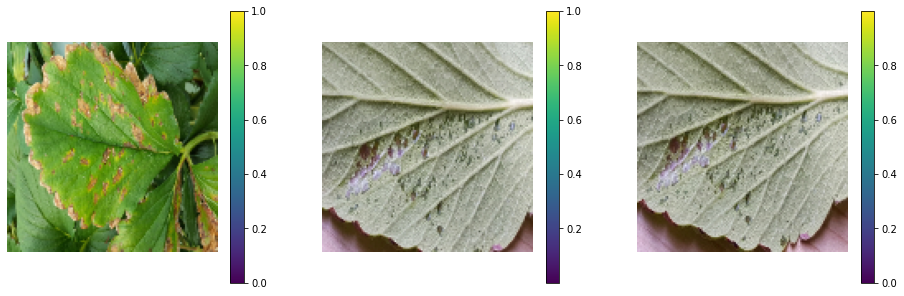

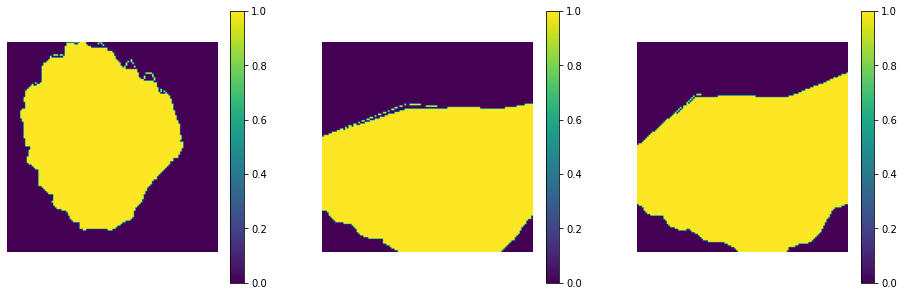

In [23]:
plt.figure(figsize=(16,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = X[i]
    plt.imshow(img)
    plt.colorbar()
    plt.axis('off')
plt.show()


# plot masks
plt.figure(figsize=(16,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = y[i]
    plt.imshow(img)
    plt.colorbar()
    plt.axis('off')
plt.show()

In [24]:
X[0].dtype, y[0].dtype, test_X[0].dtype, test_y[0].dtype

(dtype('float32'), dtype('float64'), dtype('float32'), dtype('float64'))

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
print(len(X_train))
print(len(X_val))


1160
290


<h3>Convert masks to categorical (model will expect them one hot encoded)</h3>

In [26]:
from tensorflow.keras.utils import to_categorical

train_masks_categorical = to_categorical(y_train, num_classes = 2)
y_train = train_masks_categorical.reshape((y_train.shape[0], y_train.shape[1],y_train.shape[2], 2))
y_train.shape

(1160, 128, 128, 2)

In [27]:
val_masks_categorical = to_categorical(y_val, num_classes = 2)
y_val = val_masks_categorical.reshape((y_val.shape[0], y_val.shape[1],y_val.shape[2], 2))
y_val.shape

(290, 128, 128, 2)

In [28]:
test_masks_categorical = to_categorical(test_y, num_classes = 2)
test_y = test_masks_categorical.reshape((test_y.shape[0], test_y.shape[1],test_y.shape[2], 2))
test_y.shape

(743, 128, 128, 2)

<h1>Fully Convolutional Neural Network for Transfer Learning</h1>  

We will build a model using existing trained network. Library used to import model is segmentation_models, and this library is known for segmentation networks. It is really straightforward if one is not experienced in semantic segmentation image processing. Resnet34 is used as a backbone, and some other available nets that can be used for this task are inception and VGG.

In [29]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to c:\users\aleks\appdata\local\temp\pip-req-build-c5tikh7t
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123


  Running command git clone -q https://github.com/qubvel/segmentation_models 'C:\Users\aleks\AppData\Local\Temp\pip-req-build-c5tikh7t'
  Running command git submodule update --init --recursive -q


In [30]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [31]:
# X_train = X_train.astype(np.float32)
# y_train = y_train.astype(np.float32)
# X_val = X_val.astype(np.float32)
# y_val = y_val.astype(np.float32)

In [32]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
test_X = preprocess_input(test_X)

<h2>Performance Metrics</h2>  
Below are two most common performance metrics used for semantic segmentation.  

<h3>IOU (Jaccard Index)</h3>
area of overlap / area of union  
  
Jaccard index in semantic segmentation represents relation between area of overlap of segmented image and ground truth vs area of union of segmented image and ground truth. It ranges from 0 to 1, with lower values pointing to less overlap, while values closer to one present better prediction. 1 means perfect overlap, while 0 no overlap. This metric is prefered over pixel accuracy, as pixel accuracy can be missleading in cases. IOU gives us more reliable measure of model performance, as it compares the percentage of actual overlap area between two masks.  
  
<h3>Dice Coefficient (F1 Score)</h3>  
(2*area of overlap)/ number of pixels in both images  
  
Somewhat similar in concept, this measure shows the relation of correctly classified pixels out of total amount. Dice Coefficient is positively correlated to Jacard Coefficient, meaning that if model showed good IOU score it will likely show good dice coefficient as well. Dice coefficient also ranges from 0 to 1, with values closer to 0 showing bad and values close to 1 showing good performance.  
  
<h3>Dice Loss</h3>  
  
Dice loss directly utilizes dice coefficient to measure loss. As crossentropy is an accuracy-oriented measure, it is not suited for semantic segmentation. Dice loss is more focused on negative classes and is said to be more immune to data disbalance.

https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

In [33]:
dice_loss = sm.losses.DiceLoss(class_weights = np.array([.5,.5]))
metrics = [sm.metrics.IOUScore(), sm.metrics.FScore()]

learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate)


In [34]:
model = Unet(backbone_name='resnet34', encoder_weights='imagenet', classes = 2 , activation = 'softmax')
model.compile(optimizer, loss = dice_loss,metrics = metrics)

In [35]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

                                                                                                  
 stage1_unit3_bn1 (BatchNormali  (None, None, None,   256        ['add_1[0][0]']                  
 zation)                        64)                                                               
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, None, None,   0          ['stage1_unit3_bn1[0][0]']       
 )                              64)                                                               
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, None, None,   0          ['stage1_unit3_relu1[0][0]']     
 D)                             64)                                                               
                                                                                                  
 stage1_un

                                128)                              'add_3[0][0]']                  
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, None, None,   512        ['add_4[0][0]']                  
 zation)                        128)                                                              
                                                                                                  
 stage2_unit3_relu1 (Activation  (None, None, None,   0          ['stage2_unit3_bn1[0][0]']       
 )                              128)                                                              
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, None, None,   0          ['stage2_unit3_relu1[0][0]']     
 2D)                            128)                                                              
          

 add_7 (Add)                    (None, None, None,   0           ['stage3_unit1_conv2[0][0]',     
                                256)                              'stage3_unit1_sc[0][0]']        
                                                                                                  
 stage3_unit2_bn1 (BatchNormali  (None, None, None,   1024       ['add_7[0][0]']                  
 zation)                        256)                                                              
                                                                                                  
 stage3_unit2_relu1 (Activation  (None, None, None,   0          ['stage3_unit2_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, None, None,   0          ['stage3_unit2_relu1[0][0]']     
 2D)      

                                                                                                  
 stage3_unit5_bn1 (BatchNormali  (None, None, None,   1024       ['add_10[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit5_relu1 (Activation  (None, None, None,   0          ['stage3_unit5_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_24 (ZeroPadding  (None, None, None,   0          ['stage3_unit5_relu1[0][0]']     
 2D)                            256)                                                              
                                                                                                  
 stage3_un

                                512)                              'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, None, None,   2048       ['add_13[0][0]']                 
 zation)                        512)                                                              
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, None, None,   0          ['stage4_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 zero_padding2d_30 (ZeroPadding  (None, None, None,   0          ['stage4_unit2_relu1[0][0]']     
 2D)                            512)                                                              
          

                                                                                                  
 decoder_stage0b_relu (Activati  (None, None, None,   0          ['decoder_stage0b_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, None, None,   0          ['decoder_stage0b_relu[0][0]']   
 ampling2D)                     256)                                                              
                                                                                                  
 decoder_stage1_concat (Concate  (None, None, None,   0          ['decoder_stage1_upsampling[0][0]
 nate)                          384)                             ',                               
                                                                  'stage3_unit1_relu1[0][0]']     
          

                                16)                              ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, None, None,   64         ['decoder_stage4a_conv[0][0]']   
 lization)                      16)                                                               
                                                                                                  
 decoder_stage4a_relu (Activati  (None, None, None,   0          ['decoder_stage4a_bn[0][0]']     
 on)                            16)                                                               
                                                                                                  
 decoder_stage4b_conv (Conv2D)  (None, None, None,   2304        ['decoder_stage4a_relu[0][0]']   
                                16)                                                               
          

In [36]:
print(len(X_train))
print(len(y_train))

1160
1160


In [37]:
history = model.fit(X_train, y_train, batch_size = 16, epochs = 50, verbose = 1, validation_data = (X_val, y_val))

Epoch 1/50
73/73 [==============================] - 237s 3s/step - loss: 0.7052 - iou_score: 0.4324 - f1-score: 0.5901 - val_loss: 0.7510 - val_iou_score: 0.3728 - val_f1-score: 0.4977
Epoch 2/50
73/73 [==============================] - 223s 3s/step - loss: 0.6304 - iou_score: 0.5995 - f1-score: 0.7391 - val_loss: 0.7581 - val_iou_score: 0.3705 - val_f1-score: 0.4829
Epoch 3/50
73/73 [==============================] - 230s 3s/step - loss: 0.6056 - iou_score: 0.6638 - f1-score: 0.7889 - val_loss: 0.7677 - val_iou_score: 0.3714 - val_f1-score: 0.4629
Epoch 4/50
73/73 [==============================] - 248s 3s/step - loss: 0.5938 - iou_score: 0.6957 - f1-score: 0.8127 - val_loss: 0.7814 - val_iou_score: 0.3647 - val_f1-score: 0.4357
Epoch 5/50
73/73 [==============================] - 246s 3s/step - loss: 0.5821 - iou_score: 0.7265 - f1-score: 0.8351 - val_loss: 0.7840 - val_iou_score: 0.3629 - val_f1-score: 0.4304
Epoch 6/50
73/73 [==============================] - 216s 3s/step - loss: 0.

73/73 [==============================] - 249s 3s/step - loss: 0.5164 - iou_score: 0.9373 - f1-score: 0.9671 - val_loss: 0.5971 - val_iou_score: 0.6832 - val_f1-score: 0.7954
Epoch 46/50
73/73 [==============================] - 237s 3s/step - loss: 0.5157 - iou_score: 0.9391 - f1-score: 0.9681 - val_loss: 0.5944 - val_iou_score: 0.6902 - val_f1-score: 0.8011
Epoch 47/50
73/73 [==============================] - 217s 3s/step - loss: 0.5184 - iou_score: 0.9307 - f1-score: 0.9634 - val_loss: 0.5962 - val_iou_score: 0.6882 - val_f1-score: 0.8005
Epoch 48/50
73/73 [==============================] - 215s 3s/step - loss: 0.5175 - iou_score: 0.9335 - f1-score: 0.9651 - val_loss: 0.5961 - val_iou_score: 0.6840 - val_f1-score: 0.7961
Epoch 49/50
73/73 [==============================] - 214s 3s/step - loss: 0.5156 - iou_score: 0.9404 - f1-score: 0.9689 - val_loss: 0.5972 - val_iou_score: 0.6813 - val_f1-score: 0.7939
Epoch 50/50
73/73 [==============================] - 218s 3s/step - loss: 0.5162 -

In [38]:
model.evaluate(test_X, test_y)

24/24 [==============================] - 19s 773ms/step - loss: 0.6469 - iou_score: 0.5761 - f1-score: 0.7024


[0.6468961238861084, 0.576105535030365, 0.7024438977241516]

In [39]:
test_img = test_X[25]
ground_truth = test_y[25]
test_img_input = np.expand_dims(test_img, 0)
test_img_input = preprocess_input(test_img_input)
test_pred = model.predict(test_img_input)
test_pred = np.argmax(test_pred, axis =3)[0,:,:]

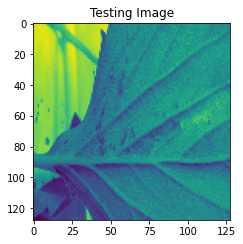

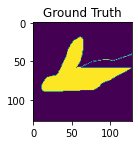

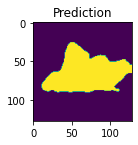

In [40]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:, 0])
plt.show()
plt.subplot(231)
plt.title('Ground Truth')
plt.imshow(ground_truth[:,:,1])
plt.show()
plt.subplot(231)
plt.title('Prediction')
plt.imshow(test_pred)
plt.show()

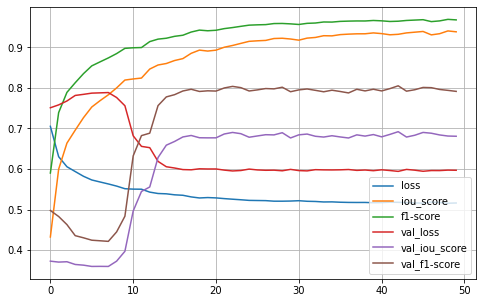

In [41]:
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca()
plt.show()

In [42]:
preds = model.predict(test_X)

<h1>References</h1>    

https://analyticsindiamag.com/my-experiment-with-unet-building-an-image-segmentation-model/  

https://segmentation-models.readthedocs.io/en/latest/tutorial.html     

https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/    

https://www.kaggle.com/code/basu369victor/transferlearning-and-unet-to-segment-rocks-on-moon/notebook  
  
https://www.youtube.com/watch?v=F365vQ8EndQ&t=1136s&ab_channel=DigitalSreeni